## My Neural Network

In [2]:
import numpy as np
import scipy as sc

import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

## Treat input and output

In [49]:
def to_1_hot_encoding(output):
    one_hot = [0] * 10
    one_hot[int(output)] = 1
    
    return one_hot

## Datasets

In [51]:
raw_data = np.loadtxt("poker-hand-training-true.data", delimiter=",")

np.random.seed(10)
np.random.shuffle(raw_data)
ratio = 85 * raw_data.shape[0] // 100
training, test = raw_data[:ratio, :], raw_data[ratio:, :]

training_input, training_output = training[:, :-1], training[:, -1]
test_input, test_output = test[:, :-1], test[:, -1]

training_output_hot = np.array(list(map(to_1_hot_encoding, training_output)))
test_output_hot = np.array(list(map(to_1_hot_encoding, test_output)))

## Activation functions

In [56]:
# function, derivate
sigm = lambda x : 1 / (1 + np.exp(-x))

sigmoid = (
    lambda x : sigm(x),
    lambda x : sigm(x) * (1 - sigm(x))
)

ReLU = (
    lambda x : x * (x > 0),
    lambda x : 1 * (x > 0)
)

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)


### Cost function

In [53]:
# function, derivate
mean_square_error = (
    lambda prediction, real : np.mean((prediction - real) ** 2),
    lambda prediction, real : (prediction - real)
)

## Neural Network Layer class

In [54]:
class NeuralLayer:
    def __init__(self, num_connections_entering, num_neurons, activation_fn):
        self.activation_fn = activation_fn
        
        # create from -1 to 1
        self.bias = np.random.rand(1, num_neurons) * 2 - 1
        self.weights = np.random.rand(num_connections_entering, num_neurons) * 2 - 1
        
        self.num_connections_entering = num_connections_entering
        self.num_neurons = num_neurons

# Neuronal Network

In [55]:
def create_neural_network():
    neuralNetwork = [
        NeuralLayer(num_connections_entering=10, num_neurons=25, activation_fn=ReLU),
        NeuralLayer(num_connections_entering=25, num_neurons=12, activation_fn=ReLU),
        NeuralLayer(num_connections_entering=12, num_neurons=10, activation_fn=Softmax),
    ]
    
    return neuralNetwork
    
Poker = create_neural_network()

def print_neural_network(neuralNetwork):
    list_indexes = list(range(neuralNetwork[0].num_connections_entering))
    inputs_names = list(map(lambda i: f"input {i + 1}", list_indexes))
    
    print(inputs_names, end="\n\n")
    
    for i, layer in enumerate(neuralNetwork):
        print(f"layer {i}: {layer.bias.shape[1]} neurons")
        print("weights")
        print(layer.weights, end="\n\n")
        print("bias")
        print(layer.bias, end="\n\n")
        
print_neural_network(Poker)

['input 1', 'input 2', 'input 3', 'input 4', 'input 5', 'input 6', 'input 7', 'input 8', 'input 9', 'input 10']

layer 0: 25 neurons
weights
[[ 0.32250848 -0.85224329 -0.30431693  0.6646874  -0.87029377  0.64681388
   0.06939591 -0.79191883  0.61148278 -0.61524591 -0.83821204  0.88359576
  -0.5295467   0.99119552  0.64535103  0.93294845 -0.61019911 -0.22723085
  -0.29939599  0.96512375 -0.84705954  0.37511338 -0.32438171 -0.05771315
   0.85999471]
 [-0.20742391 -0.41444505  0.93232565  0.33715923 -0.5016634   0.17010924
  -0.81397059  0.45920023  0.44907411  0.10680926 -0.66629128  0.53629371
   0.18014674 -0.90398819 -0.80577343  0.22549392 -0.4190829   0.61337137
  -0.73088194  0.79599247  0.25985784  0.48417846  0.89403799 -0.49238173
   0.46992094]
 [-0.06387152  0.51373643 -0.54688647  0.01425519 -0.67401496 -0.47697456
   0.62464514  0.70487996  0.45976565 -0.45296004  0.71385657  0.73325256
  -0.06614153  0.77012256 -0.58016063  0.70903516  0.01243934  0.27666593
  -0.46398674  

In [7]:
def foward_pass(neural_network, inputs, cost_function, print_it=True):
    input_to_layer = inputs
    steps = [(None, inputs)]
    
    for _, layer in enumerate(neural_network):
        ponderate_sum = input_to_layer @ layer.weights + layer.bias
        input_to_layer = activation = layer.activation_fn[0](ponderate_sum)
        
        steps.append((ponderate_sum, activation))
    
    if print_it:
        prediction = np.hstack((inputs, input_to_layer))
        print("Current behavior")
        print(prediction, end="\n\n")
    
    return steps

steps = foward_pass(XOR, input_dataset, mean_square_error)

Current behavior
[[0.         0.         0.38751439]
 [0.         1.         0.40262198]
 [1.         0.         0.37772657]
 [1.         1.         0.39649398]]



In [8]:
def backpropagation(neural_network, inputs, outputs, cost_function, show, learning_rate = 3.2):
    steps = foward_pass(neural_network, inputs, cost_function, show)
    deltas = [None] * len(neural_network)
    
    next_layer_weights = None
    num_layers, num_inputs = len(neural_network), inputs.shape[0]

    for i in reversed(range(num_layers)):
        ponderate_sum, activation = steps[i + 1]
        _, activation_last_layer = steps[i]
        
        if i == num_layers - 1:
            cost_activation = cost_function[1](activation, outputs)
        else:
            cost_activation = deltas[i + 1] @ next_layer_weights.T / num_inputs
            
        activation_ponderate = neural_network[i].activation_fn[1](ponderate_sum)
        deltas[i] = delta = cost_activation * activation_ponderate
        
        gradient_weights = (activation_last_layer.T @ delta) / num_inputs
        gradient_bias = np.mean(delta, axis=0, keepdims=True)
        
        next_layer_weights = neural_network[i].weights
        
        neural_network[i].bias -= learning_rate * gradient_bias
        neural_network[i].weights -= learning_rate * gradient_weights
        
    error = cost_function[0](steps[-1][1], outputs)
    return error

In [9]:
def show_step(neural_network, input_dataset, output_dataset, cost_function, show):
    error_before = backpropagation(neural_network, input_dataset, output_dataset, cost_function, show)
    print(f"current error = {error_before}")
    
    if show: 
        steps = foward_pass(neural_network, input_dataset, cost_function, False)
        error_after = cost_function[0](steps[-1][1], output_dataset)
        
        print_neural_network(neural_network)
        
        print(f"new error = {error_after}")
        print(f"difference = {abs(error_before - error_after)}", end="\n\n")
        
    return error_before
        
x = show_step(XOR, input_dataset, output_dataset, mean_square_error, True)

Current behavior
[[0.         0.         0.38751439]
 [0.         1.         0.40262198]
 [1.         0.         0.37772657]
 [1.         1.         0.39649398]]

current error = 0.26286489658054046
['input 1', 'input 2']

layer 0: 2 neurons
weights
[[ 0.26855457  0.49555428]
 [-0.00146794 -0.55075697]]

bias
[[ 0.5452862  -0.96091623]]

layer 1: 1 neurons
weights
[[ 0.57564241]
 [-0.63634415]]

bias
[[-0.52139929]]

new error = 0.25713698798167056
difference = 0.005727908598869902



In [12]:
errors = []

In [13]:
@interact_manual(times = (1, 5500))
def trainXOR(times):
    global errors
    for i in range(times):
        error = show_step(XOR, input_dataset, output_dataset, mean_square_error, False)
        errors.append(error)
        

interactive(children=(IntSlider(value=2750, description='times', max=5500, min=1), Button(description='Run Int…

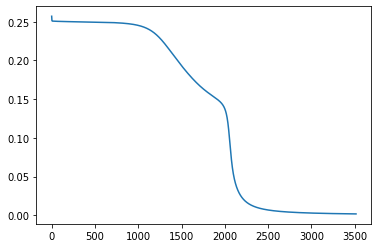

In [14]:
plt.plot(errors) 
plt.show() 